In [2]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

from utils import evaluate

# Modelado

In [3]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')

X_test  = pd.read_parquet('../data/X_test.parquet')
y_test  = pd.read_parquet('../data/y_test.parquet')

y_train = y_train['DEATH_EVENT']
y_test  = y_test['DEATH_EVENT']

In [4]:
features_selected = ['serum_sodium', 
                     'platelets', 
                     'creatinine_phosphokinase', 
                     'age',
                     'ejection_fraction',
                     'serum_creatinine'
                    ]

In [5]:
X_train = X_train.loc[: , features_selected]
X_test = X_test.loc[: , features_selected]

In [6]:
X_train.head()

,serum_sodium,platelets,creatinine_phosphokinase,age,ejection_fraction,serum_creatinine
0,138,504000.0,582,58.0,25,1.0
1,142,244000.0,161,70.0,25,1.2
2,139,365000.0,86,42.0,35,1.1
3,145,321000.0,855,82.0,50,1.0
4,140,262000.0,149,87.0,38,0.9


## Decision tree

In [7]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [8]:
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:,1]

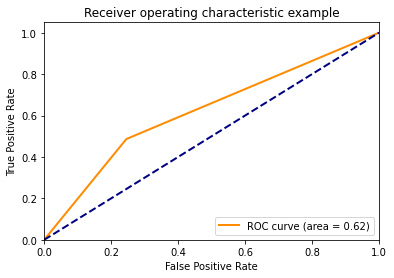

In [9]:
metrics = evaluate(y_test, y_pred, y_proba)

In [10]:
metrics

{'recall': 0.4864864864864865,
 'precision': 0.5806451612903226,
 'f1': 0.5294117647058824,
 'accuracy': 0.6444444444444445,
 'auc': 0.620601733809281}

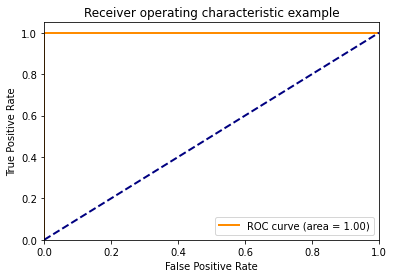

{'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'auc': 1.0}

In [11]:
# con train
y_pred = dt.predict(X_train)
y_proba = dt.predict_proba(X_train)[:,1]

evaluate(y_train, y_pred, y_proba)

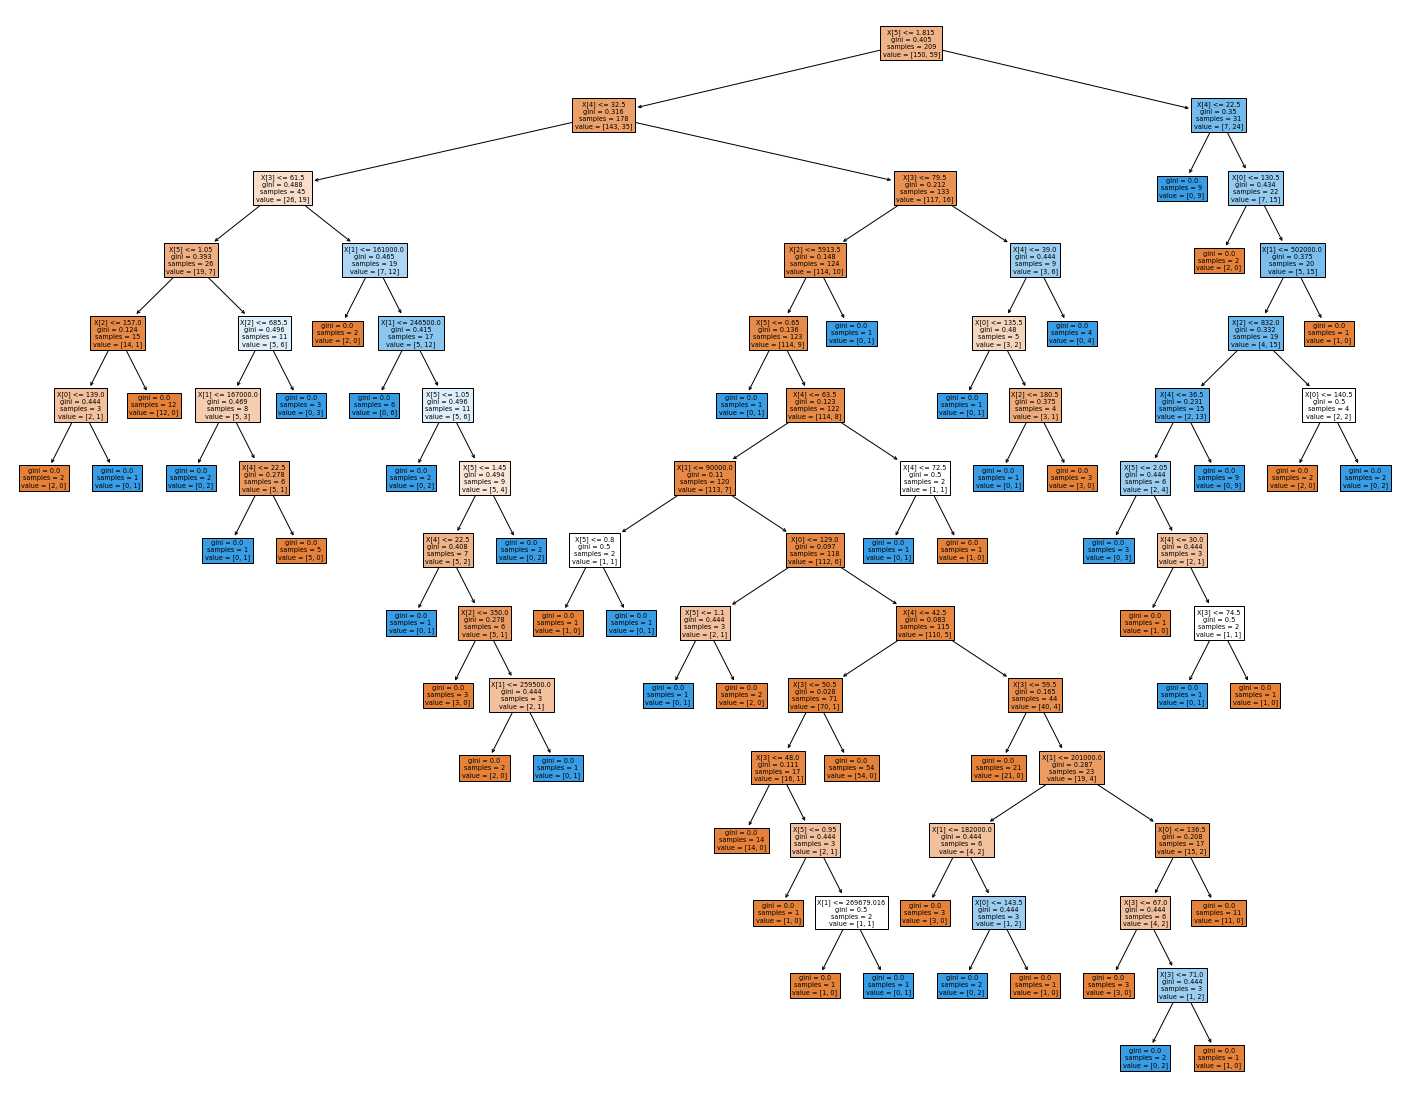

In [13]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   #feature_names= list(X_train.columns),  
                   #class_names= np.array(y_train.unique()),
                   filled=True)

In [12]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### Tuneo arbol

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
model   = DecisionTreeClassifier()
scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}

grid = {'max_depth': np.arange(2, 7, 1)}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = grid, 
                           n_jobs = -1,
                           cv = 5,
                           scoring = scoring,
                           refit = 'precision'
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6])},
             refit='precision',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'})

In [16]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.700000 using {'max_depth': 2}


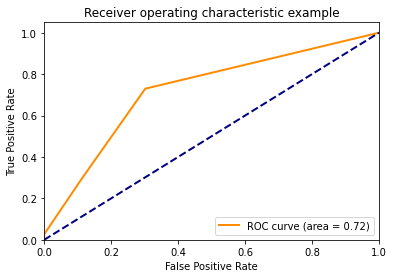

{'recall': 0.2972972972972973,
 'precision': 0.6470588235294118,
 'f1': 0.40740740740740744,
 'accuracy': 0.6444444444444445,
 'auc': 0.719020907700153}

In [17]:
dt = DecisionTreeClassifier(**grid_search.best_params_)
dt.fit(X_train, y_train)

y_pred  = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:,1]
evaluate(y_test, y_pred, y_proba)

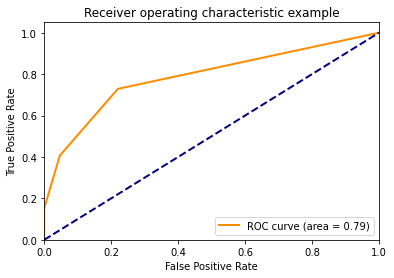

{'recall': 0.4067796610169492,
 'precision': 0.7741935483870968,
 'f1': 0.5333333333333334,
 'accuracy': 0.7990430622009569,
 'auc': 0.7857062146892655}

In [18]:
y_pred  = dt.predict(X_train)
y_proba = dt.predict_proba(X_train)[:,1]
evaluate(y_train, y_pred, y_proba)

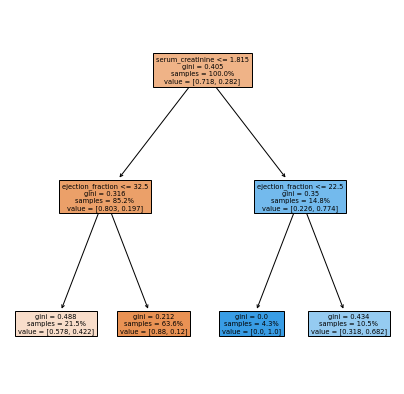

In [19]:
fig = plt.figure(figsize=(7, 7))
_ = tree.plot_tree(dt, 
                   feature_names= list(X_train.columns),  
                   #class_names= np.array(y_train.unique()),
                   filled=True, 
                   proportion = True
                  )

**Retiremos la variable tiempo para encontrar insights con las otras variables**

In [48]:
# X_train2 = X_train.drop(columns = ['time'])
# X_test2  = X_test.drop(columns = ['time'])

In [66]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [68]:
X_train.shape

(209, 12)

In [21]:
model   = DecisionTreeClassifier()
scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}

grid = {'max_depth': np.arange(2, 7, 1),
        'criterion': ['gini', 'entropy'],
        'min_samples_split': np.arange(20, 100 + 1, 10),
        'min_samples_leaf': np.arange(10, 30 + 1, 5)
        }

grid_search = GridSearchCV(estimator = model, 
                           param_grid = grid, 
                           n_jobs = -1,
                           cv = 5,
                           scoring = scoring,
                           refit = 'precision'
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6]),
                         'min_samples_leaf': array([10, 15, 20, 25, 30]),
                         'min_samples_split': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100])},
             refit='precision',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'})

In [22]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.842857 using {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 20}


In [24]:
dt = DecisionTreeClassifier(**grid_search.best_params_)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=15, min_samples_split=20)

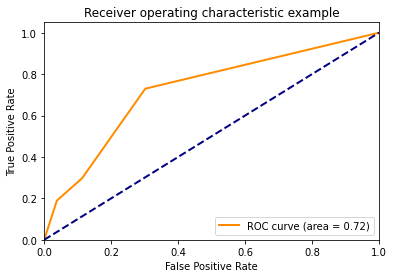

{'recall': 0.2972972972972973,
 'precision': 0.6470588235294118,
 'f1': 0.40740740740740744,
 'accuracy': 0.6444444444444445,
 'auc': 0.7225905150433454}

In [25]:
y_pred  = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:,1]
evaluate(y_test, y_pred, y_proba)

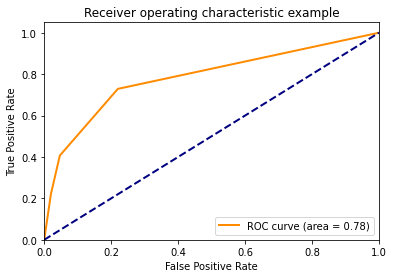

{'recall': 0.4067796610169492,
 'precision': 0.7741935483870968,
 'f1': 0.5333333333333334,
 'accuracy': 0.7990430622009569,
 'auc': 0.7832203389830508}

In [26]:
y_pred  = dt.predict(X_train)
y_proba = dt.predict_proba(X_train)[:,1]
evaluate(y_train, y_pred, y_proba)

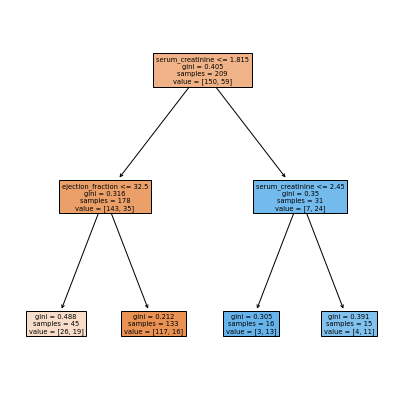

In [27]:
fig = plt.figure(figsize=(7, 7))
_ = tree.plot_tree(dt, 
                   feature_names= list(X_train.columns),  
                   #class_names= np.array(y_train.unique()),
                   filled=True, 
                   #proportion = True
                  )

In [29]:
# Guardando el modelo
import joblib

joblib.dump(dt, '../models/decision_tree.pkl')

['../models/decision_tree.pkl']

In [47]:
# importances = pd.DataFrame({'feature': X_train.columns,
#                             'importance': dt.feature_importances_ })

# importances = importances.sort_values('importance', ascending = False)

# plt.barh(x = importances['feature'].values, 
#          y = importances['importance'].values)